# 【問題1】中心点の初期値を決める

入力されたデータから$K$個の中心点$\mu_1$から$\mu_K$の初期値を決めるコードを作成してください。$K$は指定したクラスタ数です。  
最もシンプルな初期値の決定方法は、データ点$X_n$の中からランダムに$K$個選ぶことです。今回はこれを実装してください。  
K-meansの学習結果は中心点$\mu$の初期値に影響を受けます。そのため、学習時には複数個の初期値で計算を行います。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.datasets import make_blobs
X, _ = make_blobs(n_samples=100, n_features=2, centers=4, cluster_std=0.5, shuffle=True, random_state=0)

In [3]:
class ScratchKMeans():
    """
    K-meansのスクラッチ実装

    Parameters
    ----------
    n_clusters : int
      クラスタ数
    n_init : int
      中心点の初期値を何回変えて計算するか
    max_iter : int
      1回の計算で最大何イテレーションするか
    tol : float
      イテレーションを終了する基準となる中心点と重心の許容誤差
    verbose : bool
      学習過程を出力する場合はTrue
    """
    def __init__(self, n_clusters, n_init, max_iter, tol, verbose=False):
        # ハイパーパラメータを属性として記録
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose
        self.sse = np.inf
        self.myu = None
        self.r = None
        
    def fit_many_times(self, X):
        """
        n_init回だけ初期値を発生させて、一番良いものを保持する。
        parameters
        X (2d-ndarray, (n_samples, n_features)): 訓練データの特徴量
        """
        for initial in range(self.n_init):
            # Loopごとに乱数を変える
            np.random.seed(initial)
            
            # クラスタリング
            sse, myu, r = self.fit(X)
            
            # sseが前回より良かったら、myuを保持（最初だったら無条件でmyuを保持）
            if sse < self.sse or initial == 0:
                self.sse = sse
                self.myu = myu
                self.r = r

            # 学習過程を表示
            if self.verbose:
                print("{}回目:\nsse = {} \nmyu:\n{}".format(initial, sse, myu))
    
    def fit(self, X):
        """
        K-meansによるクラスタリングを計算
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        """
        # 中心点の初期値を生成
        myu = self._initial_centers(X)
        
        for i in range(self.max_iter):
            # クラスタ割り当て行列を計算
            r = self._assign_cluster(X, myu)

            # 次の中心点を求める
            new_myu = self._move_centers(X, r)

            # 中心点（myu）と重心（次の中心点new_myu）の差の合計を計算
            delta_myu = np.linalg.norm(new_myu - myu)
            #print("iteration: {} \t delta_myu: {}".format(iteration, delta_myu))

            # max_iterまで繰り返す、もしくは、中心点の移動がtol未満の場合、終了
            if delta_myu < self.tol:
                break
                
            # 中心点を更新する
            myu = new_myu

        # SSEを計算
        sse = self._calc_sse(X, new_myu, r)
        return sse, new_myu, r        
    
    
    def _initial_centers(self, X):
        """
        中心点の初期値を設定
        parameters
        X (float 2d-ndarray, (n_samples, n_features)): 訓練データの特徴量
        returns
            myu (float 2d-ndarray, (n_cluster, n_features)): 初期の中心点
        """
        # Xの中からk個ランダムに選ぶ
        random_idx = np.random.choice(X.shape[0], size=self.n_clusters, replace=False)
        myu = X[random_idx, :]
        return myu
    
    def _calc_sse(self, X, myu, r):
        """
        SSEを求める関数
        parameters
        X (float 2d-ndarray, (n_samples, n_features)): 訓練データの特徴量
        myu (float 2d-ndarray, (n_cluster, n_features)): 中心点
        r (bool 2d-ndarray, (n_samples, n_clusters)): one-hotクラスタ分類表
        returns
            sse (float): 残差平方和
        """
        sse = 0
        # 各中心点ごとに見ていく
        for k in range(self.n_clusters):
            # クラスタ割り当て行列rと中心点μの
            r_k = r[:, k]
            
            # k番目のクラスタの中心点を取得
            m_k = myu[k, :].reshape(1, -1)  # reshapeは、軸がないとブロードキャストできないから軸を追加
            
            # k番目のクラスタにおけるsseを計算して合計する
            sse_k = np.sum((X[r_k] - m_k)**2)
            
            sse += sse_k
        return sse
    
    def _assign_cluster(self, X, myu):
        """
        クラスタを割り当てる関数
        parameters
            X (2d-ndarray, (n_samples, n_features)): 訓練データの特徴量
            myu (2d-ndarray, (n_cluster, n_features)): 中心点
        returns
            r (bool 2d-ndarray, (n_samples, n_clusters)): one-hotクラスタ分類表
        """
        # ユークリッド距離を格納する行列d
        d = np.zeros((X.shape[0], self.n_clusters))

        # クラスタごとに回してデータと中心点との距離を計算していく
        for k in range(self.n_clusters):
            # 中心点のベクトルm_kを取得
            m_k = myu[k, :].reshape(1, -1)  # 1d-array（軸がない）場合、ブロードキャストできないので２軸目追加
            #ブロードキャスト使わない場合：m_k = np.tile(myu[k, :], (X.shape[0], 1))
            
            # X - m_kの距離を計算
            d_k = np.linalg.norm(X - m_k , ord=2, axis=1)
            
            # 行列dのk列目に代入
            d[:, k] = d_k

        # データごとに、どのクラスタ中心点との距離が最小なのか判定する
        min_vec = np.min(d, axis=1).reshape(-1, 1)

        # 距離の最小値でできた行列（Xと同じ形状）を作る
        #ブロードキャストしない場合：min_matrix = np.tile(min_vec, (1, self.n_clusters))

        # 距離が最小ならばTrue、それ以外はFalseの行列をrとする
        # ブロードキャストしない場合：r = d == min_matrix
        r = d == min_vec
        return r
    
    def _move_centers(self, X, r):
        """
        中心点を更新する関数
        parameters
            X (float 2d-ndarray, (n_samples, n_features)): データ
            r (bool 2d-ndarray, (n_samples, n_clusters)): クラスタ分類表
        returns
            new_myu (float 2d-ndarray, (n_clusters, n_features)): 新しい中心点（クラスタの重心）
        """
        # myuと同じ形状のゼロ行列を定義（これに入れていく）
        new_myu = np.zeros((self.n_clusters, X.shape[1]))
        
        # クラスタごとに中心点を求める
        for k in range(self.n_clusters):
            # k番目の r で、そのクラスタに属しているデータを選択
            # その平均を行方向に計算する
            new_myu[k, :] = np.mean(X[r[:, k]], axis=0)
        return new_myu
    
    def predict(self, X):
        """
        入力されたデータがどのクラスタに属するかを計算
        """
        r = self._assign_cluster(X, self.myu)
        label = np.argmax(r, axis=1)  # Trueのインデックスを選ぶ
        return label

In [4]:
def choose_K_points(X, K):
    return X[np.random.choice(X.shape[0], K, replace=False), :]

以下のメソッドをScratchKMeansに実装した。  
```python
def _initial_centers(self, X):
    """
    中心点の初期値を設定
    parameters
    X (float 2d-ndarray, (n_samples, n_features)): 訓練データの特徴量
    returns
        myu (float 2d-ndarray, (n_cluster, n_features)): 初期の中心点
    """
    # Xの中からk個ランダムに選ぶ
    random_idx = np.random.choice(X.shape[0], size=self.n_clusters, replace=False)
    myu = X[random_idx, :]
    return myu
```

# 【問題2】SSEを求める関数の作成

クラスタ内誤差平方和（SSE, Sum of Squared Errors）を計算する関数を作成してください。  
K-meansはこのSSEを最小化する$r_{nk}$と$\mu_k$を求めることが目的となります。  
複数個の初期値で計算したクラスタリング結果から、どれを最終的に採用するかを決める際にこのSSEを求める関数を使用します。
$$
SSE = \sum_{n=1}^N \sum_{k=1}^K r_{nk} \|X_n - \mu_k\|^2
$$
$n$: データ点のインデックス  
$k$: クラスタのインデックス  
$X_n$: $n$番目のデータ点  
$\mu_k$: $k$番目の中心点  
$r_{nk}$: データ点$X_n$がクラスタ$k$に属していたら1, そうでなければ0

以下のメソッドをScratchKMeansに実装した。
```python
def _calc_sse(self, X, myu, r):
    """
    SSEを求める関数
    parameters
    X (float 2d-ndarray, (n_samples, n_features)): 訓練データの特徴量
    myu (float 2d-ndarray, (n_cluster, n_features)): 中心点
    r (bool 2d-ndarray, (n_samples, n_clusters)): one-hotクラスタ分類表
    returns
        sse (float): 残差平方和
    """
    sse = 0
    # 各中心点ごとに見ていく
    for k in range(self.n_clusters):
        # クラスタ割り当て行列rと中心点μの
        r_k = r[:, k]

        # k番目のクラスタの中心点を取得
        m_k = myu[k, :].reshape(1, -1)  # reshapeは、軸がないとブロードキャストできないから軸を追加

        # k番目のクラスタにおけるsseを計算して合計する
        sse_k = np.sum((X[r_k] - m_k)**2)

        sse += sse_k
    return sse
```

# 【問題3】クラスタへの割り当て

全てのデータ点$X_n$を最も近い中心点$\mu_k$に割り当てるコードを作成してください。  
K-menasにおける **近い** とは点と点のユークリッド距離が小さくなることです。  
ユークリッド距離とはピタゴラスの定理（三平方の定理）で求められるものですが、  
ベクトル$p,q$に対しては以下の数式で表現できます。
$$
\|q-p\| = \sqrt{(q-p)\cdot(q-p)}
$$
NumPyにはこの関数がnp.linalg.normとして用意されているため使用してください。  
numpy.linalg.norm — NumPy v1.17 Manual  
中心点$\mu_k$を固定した上でSSEを最小化していることになりますが、SSE自体を求める必要はありません。

以下のメソッドをScratchKMeansに実装した。
```python
def _assign_cluster(self, X, myu):
    """クラスタを割り当てる関数
    :parameters
        X (2d-ndarray, (n_samples, n_features)): 訓練データの特徴量
        myu (2d-ndarray, (n_cluster, n_features)): 中心点
    :returns
        r (bool 2d-ndarray, (n_samples, n_clusters)): one-hotクラスタ分類表
    """
    # ユークリッド距離を格納する行列d
    d = np.zeros((X.shape[0], self.n_clusters))

    # クラスタごとに回してデータと中心点との距離を計算していく
    for k in range(self.n_clusters):
        # 中心点のベクトルm_kを取得
        m_k = myu[k, :].reshape(1, -1)  # 1d-array（軸がない）場合、ブロードキャストできないので追加
        #ブロードキャスト使わない場合：m_k = np.tile(myu[k, :], (X.shape[0], 1))

        # X - m_kの距離を計算
        d_k = np.linalg.norm(X - m_k , ord=2, axis=1)

        # 行列dのk列目に代入
        d[:, k] = d_k

    # データごとに、どのクラスタ中心点との距離が最小なのか判定する
    min_vec = np.min(d, axis=1).reshape(-1, 1)

    # 距離の最小値でできた行列（Xと同じ形状）を作る
    #ブロードキャストしない場合：min_matrix = np.tile(min_vec, (1, self.n_clusters))

    # 距離が最小ならばTrue、それ以外はFalseの行列をrとする
    # ブロードキャストしない場合：r = d == min_matrix
    r = d == min_vec
    return r
```

# 【問題4】中心点の移動

中心点$\mu_k$を$k$番目のクラスタに割り当てられる全てのデータ点$X_n$の平均値（重心）に移動するコードを作成してください。  
クラスタの割り当て$r_{nk}$を固定した上でSSEを最小化していることになりますが、SSE自体を求める必要はありません。

以下のメソッドをScratchKMeansに実装した。
```python
def _move_centers(self, X, r):
    """中心点を更新する関数
    :parameters
        X (float 2d-ndarray, (n_samples, n_features)): データ
        r (bool 2d-ndarray, (n_samples, n_clusters)): クラスタ分類表
    :returns
        new_myu (float 2d-ndarray, (n_clusters, n_features)): 新しい中心点（クラスタの重心）
    """
    # myuと同じ形状のゼロ行列を定義（これに入れていく）
    new_myu = np.zeros((self.n_clusters, X.shape[1]))

    # クラスタごとに中心点を求める
    for k in range(self.n_clusters):
        # k番目の r で、そのクラスタに属しているデータを選択
        # その平均を行方向に計算する
        new_myu[k, :] = np.mean(X[r[:, k]], axis=0)
    return new_myu
```

# 【問題5】繰り返し

クラスタへの割り当てと中心点の移動を繰り返すことで学習を行うコードを作成してください。  
次のどれかの条件を満たしたらこれを止めます。  
- 繰り返しが指定した回数に到達する。（雛形では引数max_iter）  
- 中心点$\mu_k$と重心の差の合計が指定した許容値以下になる。（雛形では引数tol）

以下のメソッドをScratchKMeansに実装した。
```python
def fit(self, X):
    """
    K-meansによるクラスタリングを計算
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
        訓練データの特徴量
    """
    # 中心点の初期値を生成
    myu = self._initial_centers(X)

    for i in range(self.max_iter):
        # クラスタ割り当て行列を計算
        r = self._assign_cluster(X, myu)

        # 次の中心点を求める
        new_myu = self._move_centers(X, r)

        # 中心点（myu）と重心（次の中心点new_myu）の差の合計を計算
        delta_myu = np.linalg.norm(new_myu - myu)
        #print("iteration: {} \t delta_myu: {}".format(iteration, delta_myu))

        # max_iterまで繰り返す、もしくは、中心点の移動がtol未満の場合、終了
        if delta_myu < self.tol:
            break

        # 中心点を更新する
        myu = new_myu

    # SSEを計算
    sse = self._calc_sse(X, new_myu, r)
    return sse, new_myu, r
```

# 【問題6】異なる初期値で計算

問題5の繰り返しを、指定した回数初期値を変更して計算するコードを作成してください。  
回数は雛形では引数n_initで指定します。  
複数計算した中でSSEが最小になったものが最終的な学習結果となるため、その時の中心点 𝜇𝑘 を保持しておきます。

以下のメソッドをScratchKMeansに実装した。
```python
def fit_many_times(self, X):
    """
    n_init回だけ初期値を発生させて、一番良いものを保持する。
    parameters
    X (2d-ndarray, (n_samples, n_features)): 訓練データの特徴量
    """
    for initial in range(self.n_init):
        # Loopごとに乱数を変える
        np.random.seed(initial)

        # クラスタリング
        sse, myu, r = self.fit(X)

        # sseが前回より良かったら、myuを保持（最初だったら無条件でmyuを保持）
        if sse < self.sse or initial == 0:
            self.sse = sse
            self.myu = myu
            self.r = r

        # 学習過程を表示
        if self.verbose:
            print("{}回目:\nsse = {} \nmyu:\n{}".format(initial, sse, myu))
```

# 【問題7】推定

新たなデータに対してどのクラスタに所属するかの推定の際は、学習時の1つ目のフェーズと同じことを行います。  
- データ点 𝑋𝑛 と学習で決まった中心点 𝜇𝑘 に対し、 𝑆𝑆𝐸 を最小化する 𝑟𝑛𝑘 を選ぶ。  
具体的には次のことです。  
- データ点 𝑋𝑛 を最も近い 𝜇𝑘 に割り当てる。

以下のメソッドをScratchKMeansに実装した。
```python
def predict(self, X):
    """
    入力されたデータがどのクラスタに属するかを計算
    """
    r = self._assign_cluster(X, self.myu)
    label = np.argmax(r, axis=1)  # Trueのインデックスを選ぶ
    return label
```

# 【問題8】エルボー法の実装

K-meansにおいて中心点の個数 𝑘 は人為的に決める必要がありますが、その判断方法としてエルボー法があります。  
エルボー法により中心点の個数 𝑘 を検討するためのコードを作成してください。  
SSEを縦軸、クラスタ数 𝑘 を横軸にした折れ線グラフを表示します。  
このためにK-meansのインスタンスからはSSEを取得できるようにしてください。

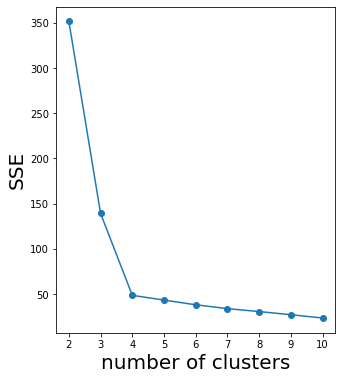

In [5]:
def draw_elbow(k_min, k_max):
    x = np.arange(k_min, k_max+1)
    y = []
    for k in range(k_min, k_max+1):
        elbow_kmeans = ScratchKMeans(n_clusters=k, n_init=10, max_iter=100, tol=1e-5, verbose=False)
        elbow_kmeans.fit_many_times(X)
        y.append(elbow_kmeans.sse)    
    # 描画
    fig, ax = plt.subplots(figsize=(5, 6))
    ax.plot(x, y, marker="o")
    ax.set_xlabel("number of clusters", fontsize=20)
    ax.set_ylabel("SSE", fontsize=20)
    plt.show()
    
draw_elbow(2, 10)

# 【問題10】クラスタ数kの選択

最適だと思われるクラスタ数 𝑘 を選択してください。  
エルボー法やシルエット図を活用する他、人間が後々どう利用したいのかも選択に関わってきます。  
選択した上で、なぜそれを選んだか説明してください。

In [6]:
# データを読み込み
data = pd.read_csv('Wholesale customers data.csv')
data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca = pca.fit(data)
data_pca = pca.transform(data)

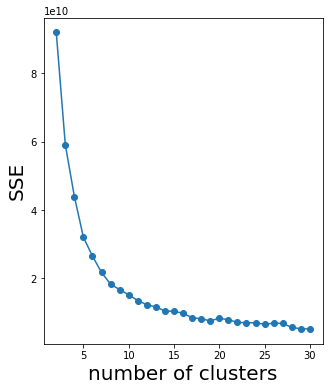

In [8]:
def draw_elbow2(X, k_min, k_max):
    x = np.arange(k_min, k_max+1)    
    y = []
    for k in range(k_min, k_max+1):
        elbow_kmeans = ScratchKMeans(n_clusters=k, n_init=10, max_iter=100, tol=1e-5, verbose=False)
        elbow_kmeans.fit_many_times(X)
        y.append(elbow_kmeans.sse)
    # 描画
    fig, ax = plt.subplots(figsize=(5, 6))
    ax.plot(x, y, marker="o")
    ax.set_xlabel("number of clusters", fontsize=20)
    ax.set_ylabel("SSE", fontsize=20)
    plt.show()

draw_elbow2(data_pca, 2, 30)

クラスタ数が10を越えたあたりからSSEの値が急減しているため、クラスタ数を10とする。

# 【問題11】既知のグループとの比較

RegionとChannelはK-meansに使用しなかったが、これれらは既知のグループです。  
クラスタとこれら既知のグループがどう違うかを確認し、説明してください。  
まずはそれぞれを可視化してください。

In [9]:
km = ScratchKMeans(n_clusters=10, n_init=10, max_iter=100, tol=1e-5, verbose=False)
X = data_pca
km.fit_many_times(X)
y = km.predict(X)

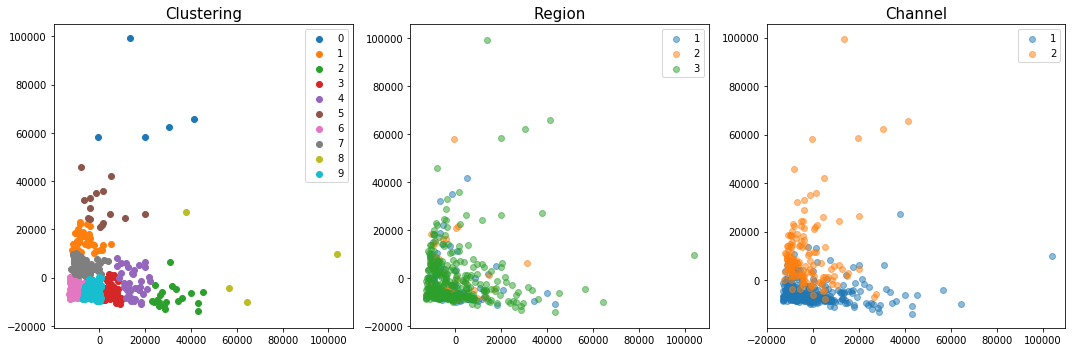

In [10]:
cluster = km.predict(X)
region = data["Region"].values
channel = data["Channel"].values

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].set_title("Clustering", fontsize=15)
for k in np.unique(cluster):
    ax[0].scatter(X[cluster == k, 0], X[cluster == k, 1], label=k)
    ax[0].legend()
    
ax[1].set_title("Region", fontsize=15)
for r in np.unique(region):
    ax[1].scatter(X[region == r, 0], X[region == r, 1], alpha=0.5, label=r)
    ax[1].legend()

ax[2].set_title("Channel", fontsize=15)
for c in np.unique(channel):
    ax[2].scatter(X[channel == c, 0], X[channel == c, 1], alpha=0.5, label=c)
    ax[2].legend()

plt.tight_layout()
plt.show()

Clusteringはクラスタが重なっておらず、データを分類できるいる。  
それに対して、Region, Channelはクラスタが重なる部分が大きく、データ分類ができていない。

# 【問題12】卸売業者にとって有益な情報

卸売業者にとって有益な情報を探し出し文章にまとめてください。  
《ヒント》  
前処理を行う前のデータを使い、各クラスタの要約統計量を見るなどしてみましょう。  
また、PCAで次元削減したデータに対してK-meansを使用しましたが、6個の特徴量をそのまま使ったり、  
一部の特徴量のみを使ったりということも試してみてください。  
既知のグループとの比較結果も参考にしてください。  
条件ごとにデータを見る際にはPandasのgroupbyが便利です。

In [11]:
data['Cluster'] = cluster

In [12]:
data.drop(["Channel", "Cluster"],axis=1).groupby("Region").sum()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Region,,,,,,
1,854833,422454,570037,231026,204136,104327
2,464721,239144,433274,190132,173311,54506
3,3960577,1888759,2495251,930492,890410,512110


In [13]:
data.drop(["Region", "Cluster"],axis=1).groupby("Channel").sum()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Channel,,,,,,
1,4015717,1028614,1180717,1116979,235587,421955
2,1264414,1521743,2317845,234671,1032270,248988


In [14]:
data.drop(["Region", "Channel"],axis=1).groupby("Cluster").sum()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Cluster,,,,,,
0,128015,217303,307361,13180,149871,13544
1,149716,439903,720044,64352,298183,56863
2,876471,77116,90718,148598,15655,46631
3,1166587,178031,244924,256450,58257,82625
4,1064238,230115,296276,187112,60555,96075
5,144907,316947,456320,31732,213919,49929
6,219984,239294,278709,178366,74446,71636
7,320702,543930,744625,95229,322397,103528
8,294186,81461,58029,78509,6716,59817


Cluster 3, 4の顧客はFreshの購入が多い。  
Cluster 1, 7の顧客はMilkの購入が多い。